### **RNN(Recurrent Neural Networks)/LSTM(Long Short Term Memory) 순환신경망을 사용하여 특정 회사의 주식 가격을 예측하는 모델을 만들어본다.**

### 데이터 출처 : Yahoo Finance


# **Library import**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

# **Load Dataset**

In [2]:
from google.colab import files
files.upload()

MessageError: ignored

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/TNT Study - code/week7/naver.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-04-26,132600.0,134400.0,129800.0,130800.0,129591.664063,789600.0
1,2016-04-27,129600.0,133000.0,128000.0,133000.0,131771.343750,403340.0
2,2016-04-28,138200.0,138200.0,129200.0,131800.0,130582.414063,1141055.0
3,2016-04-29,133600.0,136200.0,133200.0,135400.0,134149.187500,908665.0
4,2016-05-02,135800.0,136000.0,133400.0,135600.0,134347.312500,288895.0
...,...,...,...,...,...,...,...
1222,2021-04-20,389000.0,391500.0,387500.0,391000.0,391000.000000,417892.0
1223,2021-04-21,389000.0,389000.0,380500.0,380500.0,380500.000000,835828.0
1224,2021-04-22,382000.0,384500.0,380000.0,380500.0,380500.000000,394350.0
1225,2021-04-23,377500.0,379500.0,374000.0,378000.0,378000.000000,505140.0


In [ ]:
# data = pd.read_csv('naver.csv')
# data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-04-21,132000.0,133400.0,131200.0,133400.0,132167.656250,412070.0
1,2016-04-22,132000.0,133000.0,131400.0,132600.0,131375.031250,194870.0
2,2016-04-25,132400.0,133000.0,131000.0,132400.0,131176.875000,355620.0
3,2016-04-26,132600.0,134400.0,129800.0,130800.0,129591.664063,789600.0
4,2016-04-27,129600.0,133000.0,128000.0,133000.0,131771.343750,403340.0
...,...,...,...,...,...,...,...
1222,2021-04-15,391500.0,398500.0,386500.0,391000.0,391000.000000,889538.0
1223,2021-04-16,394500.0,395000.0,391000.0,391500.0,391500.000000,423962.0
1224,2021-04-19,391500.0,393500.0,388500.0,390000.0,390000.000000,449064.0
1225,2021-04-20,389000.0,391500.0,387500.0,391000.0,391000.000000,417892.0


- Open(시가): 주식에서 처음 거래된 가격(우리나라 오전 9시)
- Close(종가): 당일 맨 마지막 거래가 체결된 가격(우리나라 오후 3시)
- High/Low: 최고거래가/최저거래가
- Adj Close: 수정 종가라는 뜻으로 분할, 배당, 배분, 신주 발생이 된 경우를 고려해 주식 가격을 조정(adjustment)해둔 가격
- Volume: 주식거래량



# **Data preprocessing**

In [6]:
# 데이터 개수 파악
data.count()

Date         1227
Open         1222
High         1222
Low          1222
Close        1222
Adj Close    1222
Volume       1222
dtype: int64

In [7]:
# 결측치 개수 파악
data.isnull().sum()

Date         0
Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64

In [8]:
# 결측치가 있는 행 제거
data = data.dropna()
data.count()

Date         1222
Open         1222
High         1222
Low          1222
Close        1222
Adj Close    1222
Volume       1222
dtype: int64

In [9]:
# 고가와 저가의 중간 가격 구하기
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

# **Visualize time series data**

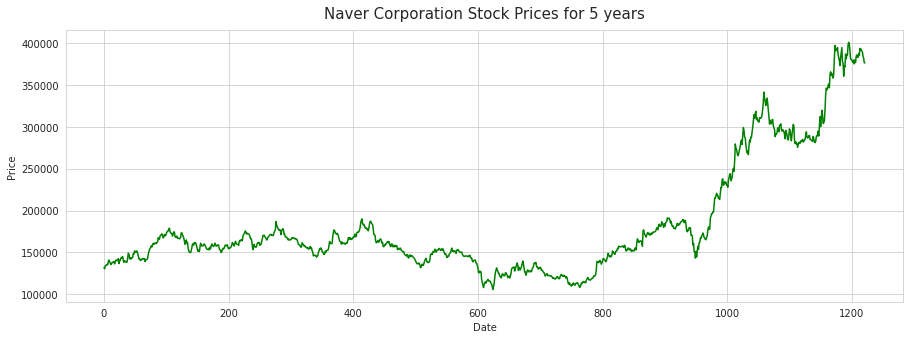

In [10]:
# 그래프로 시각화 해보기
sns.set_style('whitegrid')
plt.figure(figsize=(15, 5))
plt.plot(mid_prices, c = 'g')
plt.title("Naver Corporation Stock Prices for 5 years", size = 15, y = 1.02)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# **Create Windows**
- 첫 번째는 50일 치(1 ~ 50일)의 값으로 그 다음 날(51일)의 값을 예측한다. 
- 그리고 두 번째는 하루 밀려서 첫 날의 그 다음 날부터 50일치(2 ~ 51일)의 값으로 그 다음 날(52일)의 값을 예측한다. 
- 이러한 과정을 반복한다.

In [11]:
n_steps = 50 # time step = 50 
sequence_length = n_steps + 1 # 총 시퀀스 size

# 리스트 생성
series = [] 

# series 리스트는 index 별(배치)로 51일치의 data가 들어감. 총 길이는 전체에서 51일을 뺀 값
for i in range(len(mid_prices) - sequence_length):
    series.append(mid_prices[i:i + sequence_length]) # [0:51] -> [1:52] -> [2:53] ....

In [12]:
print("타임 스텝 :", len(series[0]))

타임 스텝 : 51


In [13]:
print("배치 사이즈 :", len(series))

배치 사이즈 : 1171


# **Normalize Data**
- Z-score 정규화

In [14]:
normalized_data = []
window_mean = []
window_std = []

# Z-Score Normalization
for window in series:
    normalized_window = [((p - np.mean(window))/np.std(window)) for p in window]
    normalized_data.append(normalized_window) 
    window_mean.append(np.mean(window))
    window_std.append(np.std(window))

# 여기서 result는 Z-Score Normalization 되어진 dataset
series = np.array(normalized_data)

# **Train Valid Test split**

In [15]:
# 전체를 7:2:1 으로 분할
row1 = int(round(series.shape[0] * 0.7))
row2 = int(round(series.shape[0] * 0.2))
print(row1, row2, len(series) - (row1+row2))

820 234 117


In [16]:
# train, valid, test 분할
X_train, y_train = series[:row1, :n_steps], series[:row1, -1]
X_valid, y_valid = series[row1:row1+row2, :n_steps], series[row1:row1+row2, -1]
X_test, y_test = series[row1+row2:, :n_steps], series[row1+row2:, -1]

In [17]:
X_train.shape, y_train.shape

((820, 50), (820,))

In [18]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train = y_train.reshape(y_train.shape[0], 1)
y_valid = y_valid.reshape(y_valid.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

X_train.shape, y_train.shape

((820, 50, 1), (820, 1))

- 학습데이터: 배치 사이즈 = 820, 타입 스텝 수 = 50, 단변량 값

# **Build a Model**

In [33]:
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [39]:
model1 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
model1.summary()

model1.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, None, 20)          820       
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
26/26 [==============================] - 1s 33ms/step - loss: 0.5585 - val_loss: 0.6003
Epoch 2/20
26/26 [==============================] - 1s 31ms/step - loss: 0.5557 - val_loss: 0.6003
Epoch 3/20
26/26 [==============================] - 1s 32ms/step - loss: 0.5542 - val_loss: 0.5970
Epoch 4/20
26/26 [==============================] - 1s 31ms/step - loss: 0.5540 - val

In [41]:
model2 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), # return_sequences 제거 -> 은닉 상태 제거
    keras.layers.Dense(1)
])

model2.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
26/26 [==============================] - 1s 34ms/step - loss: 0.5370 - val_loss: 0.5859
Epoch 2/20
26/26 [==============================] - 1s 32ms/step - loss: 0.5351 - val_loss: 0.5788
Epoch 3/20
26/26 [==============================] - 1s 30ms/step - loss: 0.5351 - val_loss: 0.5822
Epoch 4/20
26/26 [==============================] - 1s 31ms/step - loss: 0.5356 - val_loss: 0.5783
Epoch 5/20
26/26 [==============================] - 1s 33ms/step - loss: 0.5342 - val_loss: 0.5824
Epoch 6/20
26/26 [==============================] - 1s 31ms/step - loss: 0.5382 - val_loss: 0.5737
Epoch 7/20
26/26 [==============================] - 1s 32ms/step - loss: 0.5351 - val_loss: 0.5852
Epoch 8/20
26/26 [==============================] - 1s 31ms/step - loss: 0.5324 - val_loss: 0.5785
Epoch 9/20
26/26 [==============================] - 1s 31ms/step - loss: 0.5304 - val_loss: 0.5793
Epoch 10/20
26/26 [==============================] - 1s 32ms/step - loss: 0.5310 - val_loss: 0.5772
Epoch 11/

In [42]:
model2.evaluate(X_test, y_test)

4/4 [==============================] - 0s 7ms/step - loss: 1.2888


1.299278974533081

# **Training**

In [25]:
# 
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) 
    time = np.linspace(0, 1, n_steps) # 타임 스텝 길이의 직선
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

series = generate_time_series(1, n_steps + 10) # 타임스텝=50+10 = 60
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [26]:
Y_pred

array([[[0.30397955],
        [0.3437077 ],
        [0.41051298],
        [0.43901968],
        [0.5438465 ],
        [0.6452603 ],
        [0.6820669 ],
        [0.63265073],
        [0.53833306],
        [0.43690658]]], dtype=float32)

# **Prediction**

In [40]:
model1.evaluate(X_test, y_test)

4/4 [==============================] - 0s 9ms/step - loss: 2.1338


2.1742141246795654

In [22]:
# 예측값 구하기
predicted = model.predict(X_test)

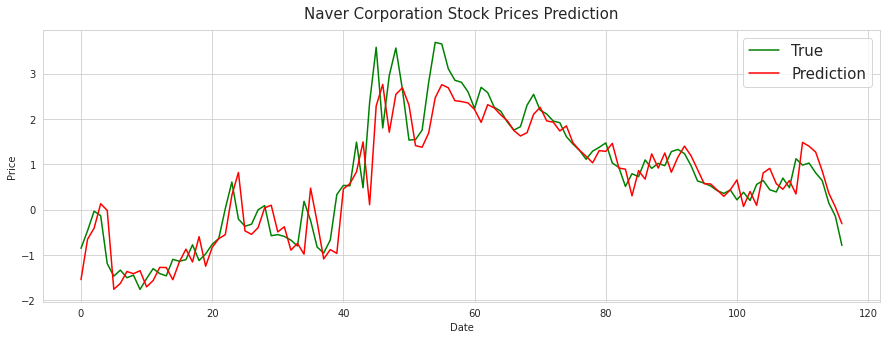

In [23]:
# 시각화
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 5))
plt.plot(y_test, label='True', c = 'g')
plt.plot(predicted, label='Prediction', c = 'r')
plt.title("Naver Corporation Stock Prices Prediction", size = 15, y = 1.02)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(fontsize = 15)
plt.show()